### Program written by Pablo Sánchez-Palencia, 2021
Scope: To check correlation between bandgaps calculated with DFT at GGA and HSE levels.

In [1]:
# Import modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
#Function to plot the predicted vs calculated values graph
def plot_comp (predval,realval,mae,r2):
    plt.figure(dpi=600)
    eje=np.linspace(1.6,2.1)
    plt.xlim([1.6,2.1])
    plt.ylim([1.6,2.1])
    plt.plot(predval,realval,'o')
    plt.plot(eje,eje)
    plt.xlabel('GGA corrected bandgaps (eV)')
    plt.ylabel('HSE calculated bandgaps (eV)')
    ax=plt.gca()
    ax.set_aspect('equal', adjustable='box')
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    xtags=xmin+0.07*(xmax-xmin)
    yperc=np.array([0.9,0.85,0.8,0.75])
    ytags=ymin+yperc*(ymax-ymin)
    plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae) +" meV")
    plt.text(xtags,ytags[1], r'R$^2$ = '+'%.3f' % r2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.close
    return

In [3]:
# Read DFT derived energies from .csv file to data frame.
hse_energies = pd.read_csv('vasp-hseenergies.csv', header=None)
gga_energies = pd.read_csv('vasp-energies.csv', header=None)
hse_energies.columns = ['tag','HSE-BGE']
gga_energies.columns = ['label','inversion','SCF','BGE']
#Look for indexes of hse structures within the gga df
with open('gga_structures_list.txt', "r") as obj_file: 
    list_gga00 = obj_file.read().splitlines()
list_gga=[i.zfill(4) for i in list_gga00]
list_hse=[i[-4:] for i in hse_energies['tag']]
indexes_gga=[list_gga.index(i) for i in list_hse]
gaps=np.array(gga_energies['BGE'][indexes_gga])
hse_energies['GGA-BGE']=gaps
inversion_rate=np.array(gga_energies['inversion'][indexes_gga])
hse_energies['y_inversion']=inversion_rate

In [4]:
#Monolinear model (only GGA bandgaps as input)
x=np.array(hse_energies['GGA-BGE']).reshape(-1,1)
y=np.array(hse_energies['HSE-BGE']).reshape(-1,1)
mae_mono=[];r2_mono=[]
coef_mono=[];intercept_mono=[]
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model_mono = linear_model.LinearRegression()
    model_mono.fit(x,y)
    y_pred = model_mono.predict(x)
    #mpe_mono=np.mean(np.abs((y-y_pred) / y)) * 100
    mae_mono.append(mean_absolute_error(y, y_pred)*1000)
    #maxe_mono=max(abs(y-y_pred))*1000
    r2_mono.append(r2_score(y,y_pred))
    coef_mono.append(model_mono.coef_)
    intercept_mono.append(model_mono.intercept_)

mean_mae_mono = np.mean(mae_mono)    
mean_r2_mono  = np.mean(r2_mono)

print('Mean absolute error {} meV'.format(mean_mae_mono))
print('R2 {} '.format(mean_r2_mono))
print(np.mean(coef_mono))
print(np.mean(intercept_mono))

Mean absolute error 7.489867888618905 meV
R2 0.9862469251760088 
1.050478716438137
1.040585279178806


In [5]:
#Bilinear model (GGA bandgaps + inversion degree as inputs)
xx=hse_energies[['GGA-BGE','y_inversion']]
yy=hse_energies['HSE-BGE']
mae_bi=[];r2_bi=[]
coef_bi=[];intercept_bi=[]
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model_bi = linear_model.LinearRegression()
    model_bi.fit(xx,yy)
    yy_pred = model_bi.predict(xx)
    #mpe_bi=np.mean(np.abs((yy-yy_pred) / yy)) * 100
    mae_bi.append(mean_absolute_error(yy, yy_pred)*1000)
    #maxe_bi=max(abs(yy-yy_pred))*1000
    r2_bi.append(r2_score(yy,yy_pred))
    coef_bi.append(model_bi.coef_)
    intercept_bi.append(model_bi.intercept_)

mean_mae_bi = np.mean(mae_bi)    
mean_r2_bi  = np.mean(r2_bi)

print('Mean absolute error {} meV'.format(mean_mae_bi))
print('R2 {} '.format(mean_r2_bi))
print(np.mean(coef_bi))
print(np.mean(intercept_bi))

Mean absolute error 1.531481859977879 meV
R2 0.999443806232444 
0.5178398903261847
1.0449794379180628


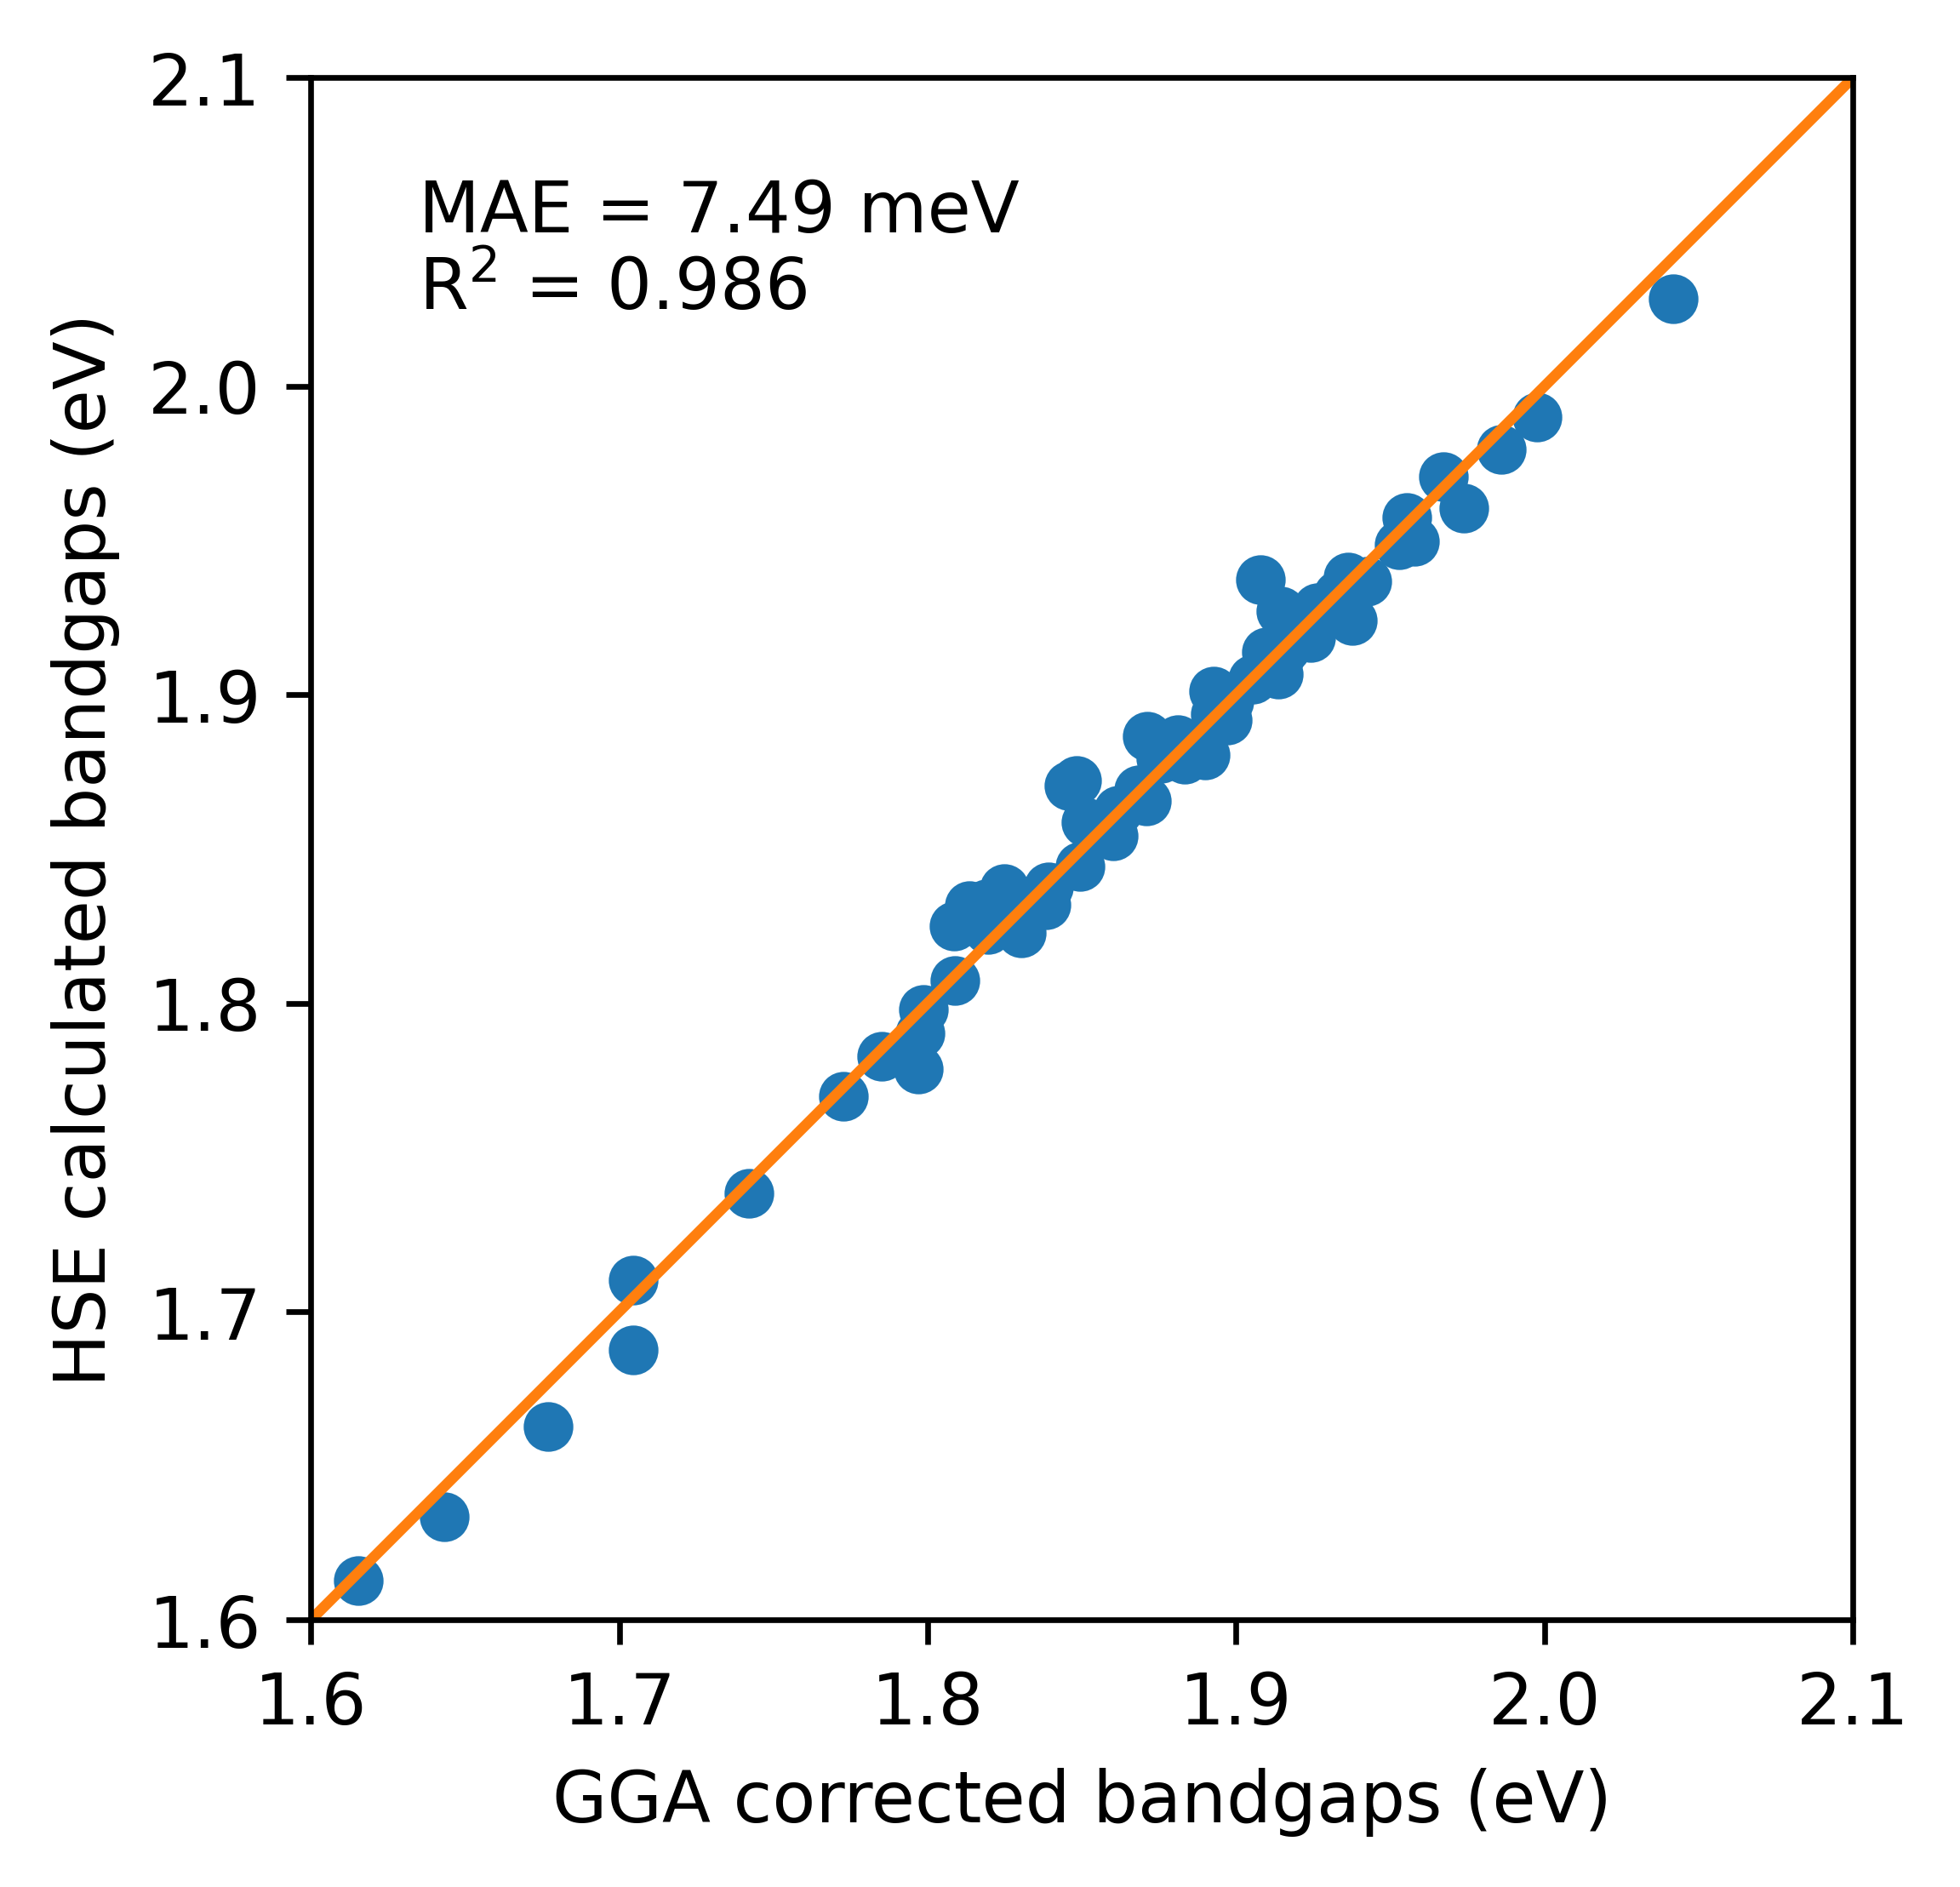

In [6]:
plot_comp(y_pred,y,mean_mae_mono,mean_r2_mono)

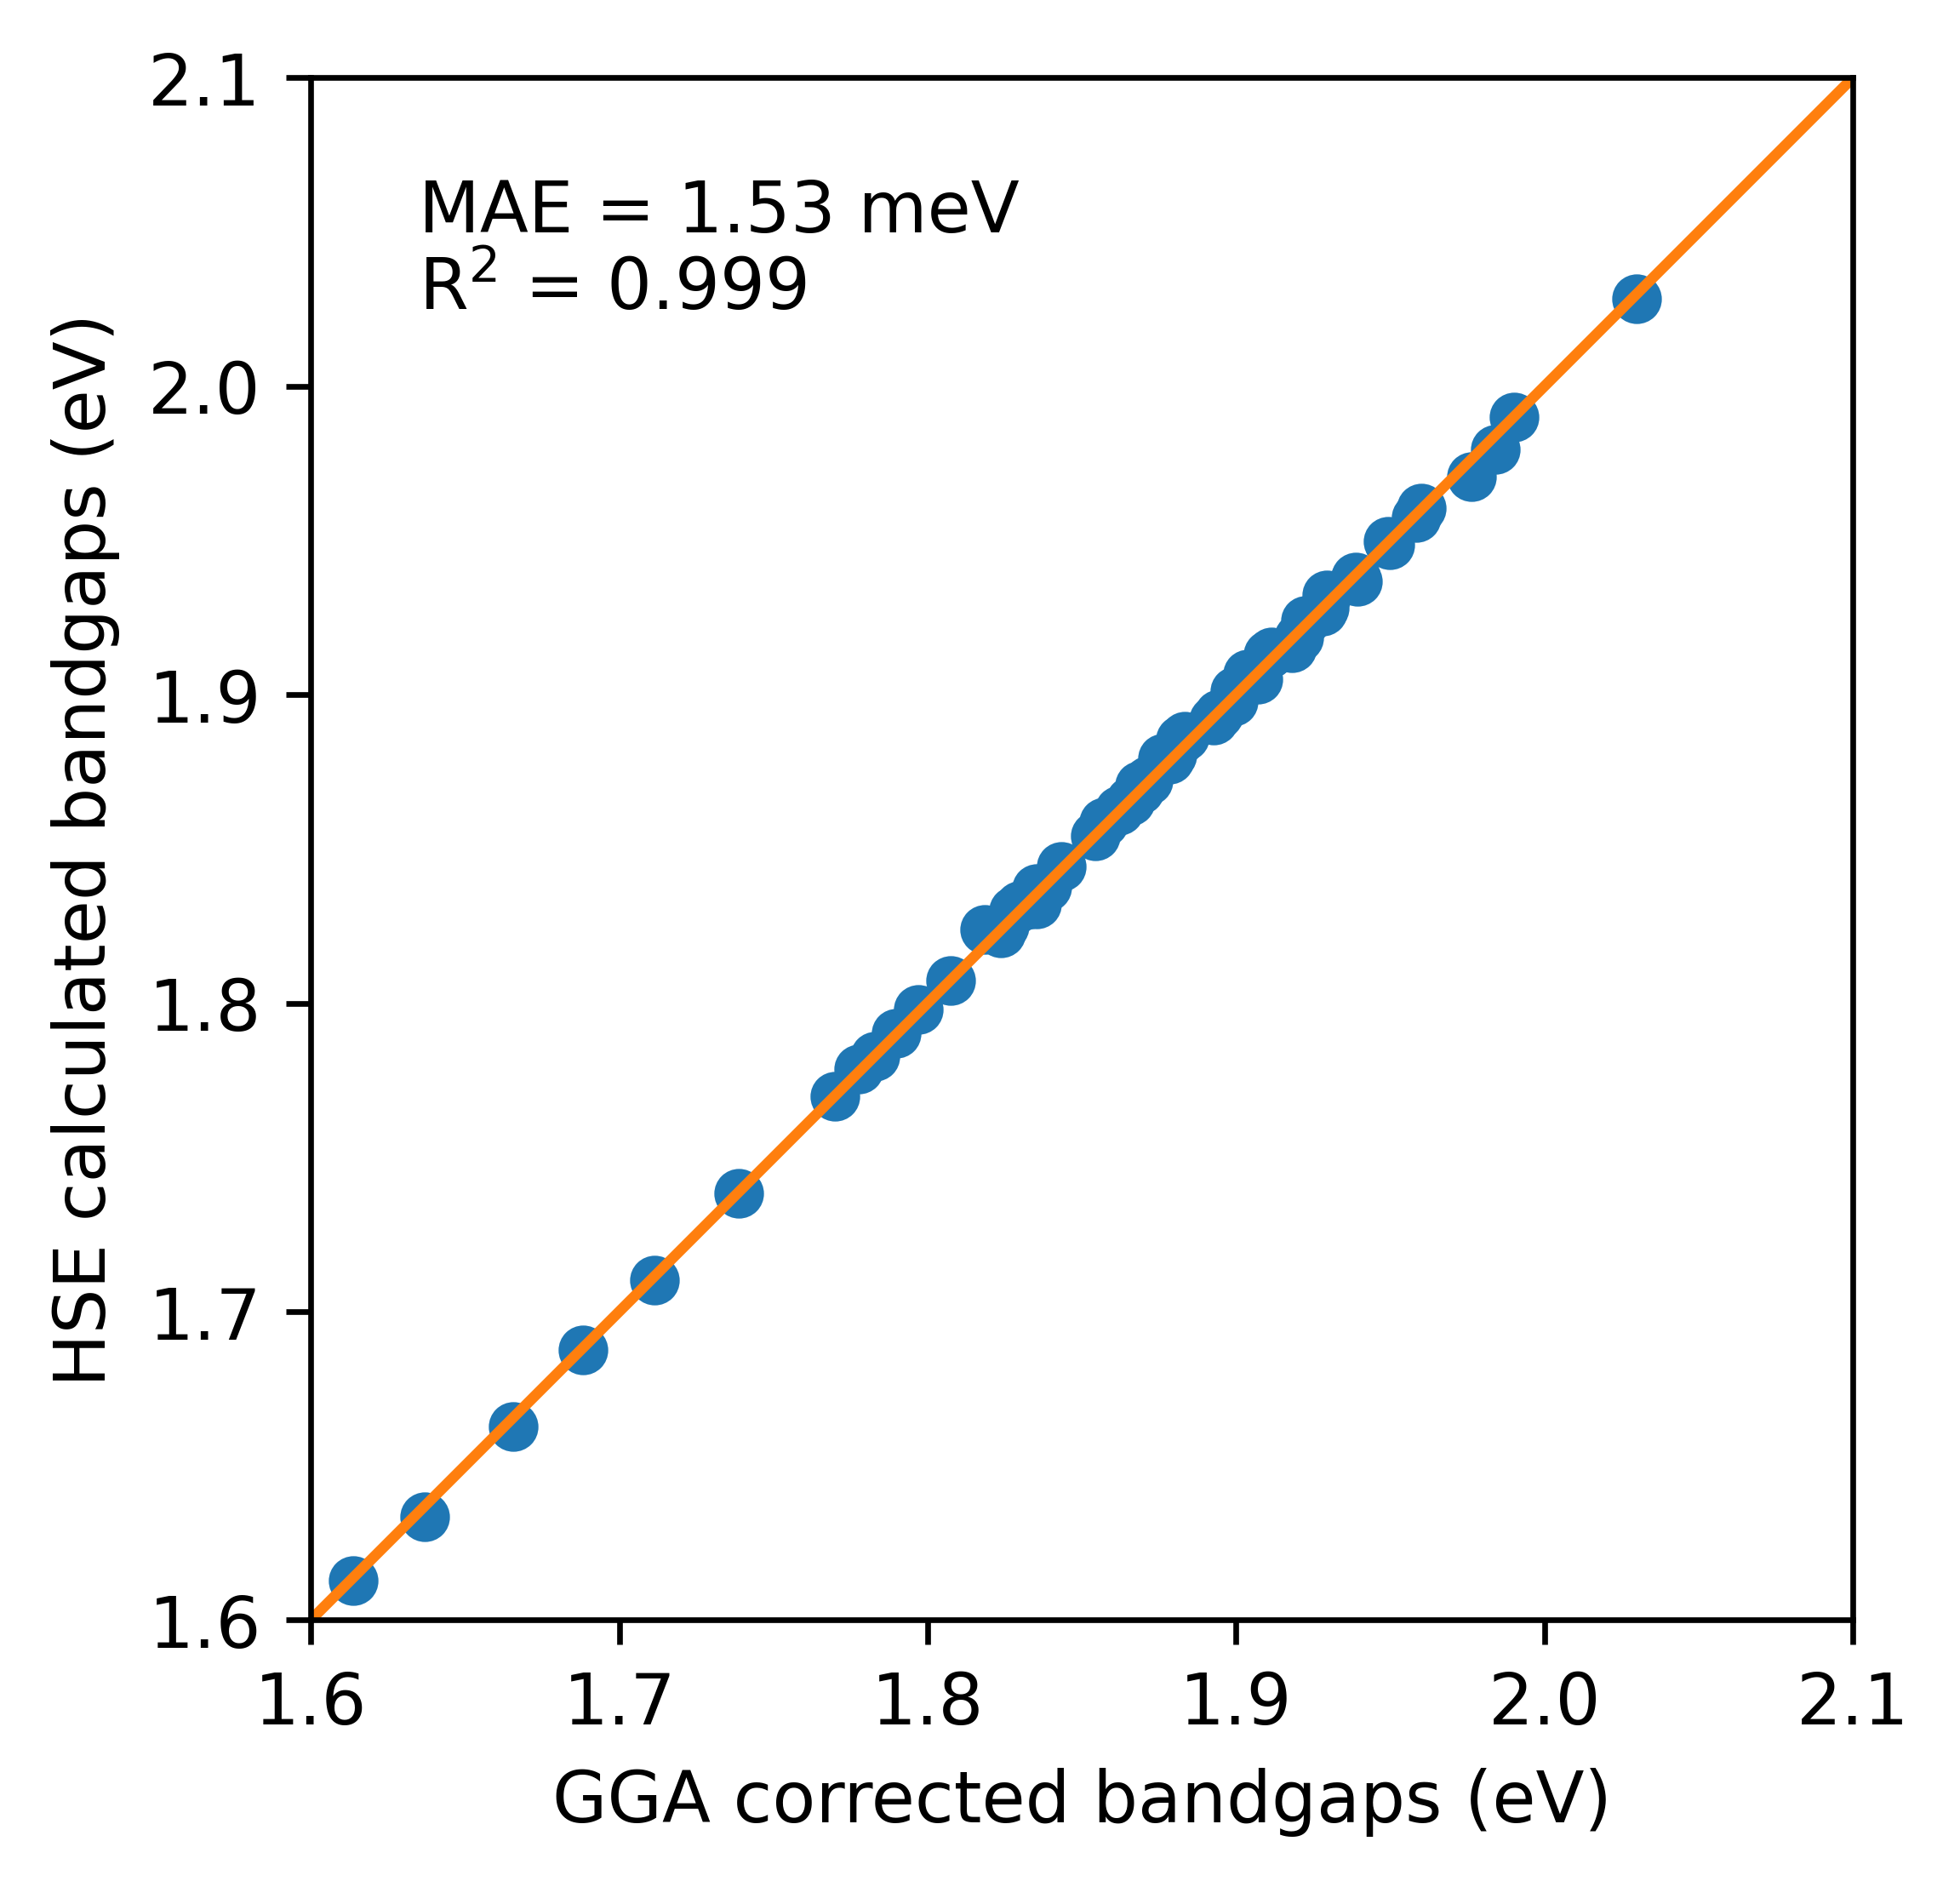

In [7]:
plot_comp(yy_pred,yy,mean_mae_bi,mean_r2_bi)

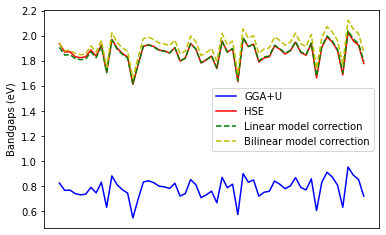

In [8]:
plt.plot(hse_energies['GGA-BGE'],'b')
plt.plot(hse_energies['HSE-BGE'],'r')
plt.plot(model_mono.coef_[0]*hse_energies['GGA-BGE']+model_mono.intercept_[0],'g--')
plt.plot(model_bi.coef_[0]*hse_energies['GGA-BGE']-model_bi.coef_[1]*hse_energies['y_inversion']+model_bi.intercept_,'y--')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel("Bandgaps (eV)")
plt.legend(["GGA+U","HSE","Linear model correction","Bilinear model correction"])
plt.show()
plt.close()